https://arxiv.org/pdf/1411.4038.pdf

# FCN Implementation

## 1. FCN Introduction

![alt text](img3.png)

![alt text](img2.png)

 Typical recognition nets, including LeNet, AlexNet, and its deeper successors, ostensibly take fixed-sized inputs and produce nonspatial outputs. The fully connected layers of these nets have fixed dimensions and throw away spatial coordinates. However, these fully connected layers can also be viewed as convolutions with kernels that cover their entire input regions.



Doing so casts them into fully convolutional networks that take input of any size and output classification maps.

In [1]:
from google.colab import auth
auth.authenticate_user()

import sys
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/My Drive/Colab Notebooks/FCN

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/FCN


### Data preparation


In [0]:
import torch
from torch.utils.data.dataset import Dataset  # For custom data-sets
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import glob
import torchvision.transforms.functional as TF
import random
from torchvision.transforms import Compose

train_img=[]
train_mask=[]
trainval_img=[]
trainval_mask=[]
val_img=[]
val_mask=[]

train = open("../Data/ImageSets/Segmentation/train.txt", 'r')
lines = train.readlines()
for i, line in enumerate(lines):
    train_img.append("../Data/JPEGImages/"+line.split('\n')[0]+".jpg")
    train_mask.append("../Data/SegmentationClass/"+line.split('\n')[0]+".png")
train.close()

trainval = open("../Data/ImageSets/Segmentation/trainval.txt", 'r')
lines = trainval.readlines()
for i, line in enumerate(lines):
    train_img.append("../Data/JPEGImages/"+line.split('\n')[0]+".jpg")
    train_mask.append("../Data/SegmentationClass/"+line.split('\n')[0]+".png")
trainval.close()

val = open("../Data/ImageSets/Segmentation/val.txt", 'r')
lines = val.readlines()
for i, line in enumerate(lines):
    val_img.append("../Data/JPEGImages/"+line.split('\n')[0]+".jpg")
    val_mask.append("../Data/SegmentationClass/"+line.split('\n')[0]+".png")
val.close()

In [0]:
from PIL import Image

img=Image.open(train_mask[0])
print(img)
plt.imshow(img)

### Normalization with simple DataLoader




In [0]:
class SimpleDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
      self.image_paths = image_paths
      self.target_paths = target_paths
      self.transforms = transforms.ToTensor()
      

    def __getitem__(self, index):
      resize=transforms.Resize(size=(520,520))
      image = Image.open(self.image_paths[index]).convert("RGB")
      mask = Image.open(self.target_paths[index]).convert("P")
      image=resize(image)
      mask=resize(mask)
      image = TF.to_tensor(image)
      mask = TF.to_tensor(mask)
      return image, mask

    def __len__(self):  # return count of sample we have
        return len(self.image_paths)


dataset = SimpleDataset(train_img, train_mask, train=True)


In [0]:
dataset =  SimpleDataset(train_img, train_mask, train=True)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=10,
    num_workers=1,
    shuffle=False
)


mean = 0.
std = 0.
nb_samples = 0.
for img, mask in loader:
    batch_samples = img.size(0)
    img = img.view(batch_samples, img.size(1), -1)
    mean += img.mean(2).sum(0)
    std += img.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [0]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):   # initial logic happens like transform
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms = transforms.ToTensor()
        
    def transform(self, image, mask):
        resize=transforms.Resize(size=(520,520))
        image=resize(image)
        mask=resize(mask)
        
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(512, 512))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        num=random.random()
        if num > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if num > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

         # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        mean=[0.4546, 0.4405, 0.4051]
        std=[0.2322, 0.2282, 0.2337]
        image[0]=(image[0]-mean[0])/std[0]
        image[1]=(image[1]-mean[1])/std[1]
        image[2]=(image[2]-mean[2])/std[2]
        
        return image, mask
    
    

    def __getitem__(self, index):
        
        image = Image.open(self.image_paths[index]).convert("RGB")
        mask = Image.open(self.target_paths[index]).convert("P")

        image, label=self.transform(image, mask)
        
        label_size=label.size
        
        # One-hot encoding 
        h = label.shape[1]
        w= label.shape[2]
        target = torch.zeros(21, h, w)
        
        label.reshape((-1,2))
        for c in range(21):
            target[c][label[0] == c] = 1

        return {'x': image, 'y':target, 'l':label[0]} 

        

    def __len__(self):  # return count of sample we have
        return len(self.image_paths)


train_dataset = CustomDataset(train_img, train_mask, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

trainval_dataset = CustomDataset(trainval_img, trainval_mask, train=False)
trainval_loader = torch.utils.data.DataLoader(trainval_dataset, batch_size=8, shuffle=False)

val_dataset = CustomDataset(val_img, val_mask, train=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)


In [10]:
train_dataset.__len__(), trainval_dataset.__len__(), val_dataset.__len__()

(3335, 0, 1111)

In [11]:
train_dataset.__getitem__(0)[0].shape

KeyError: ignored

In [0]:
train_dataset.__getitem__(0)[1].type()

### Model create

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.vgg import VGG
import pdb
import numpy as np 

In [0]:
class VGG16(VGG):
  
  def __init__(self, cfg, ranges, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
    super().__init__(self.make_layers(cfg[model]))
    
    self.ranges = ranges[model]
        
    if pretrained:
      exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)
    if not requires_grad:
      for parameter in super().parameters():
        parameter.requires_grad = False
    if remove_fc: 
      del self.classifier
    if show_params:
      for name, parameter in self.named_parameters():
        print(name, parameter.size())
        
  def forward(self, x):
    output = {}
    
    # Get the output of each maxpooling layer (There are 5 in VGG) to create skip connections.
    for idx in range(len(self.ranges)):
      for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x
    
    return output 
  
  def make_layers(self, cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

In [0]:
ranges = {'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}
cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],}

In [0]:
class FCN8s(nn.Module):
  
  def __init__(self, pretrained_model, n_classes):
    super().__init__()
    
    self.n_classes = n_classes
    self.pretrained_model = pretrained_model
    # Transposed convolutions (to upsampling previous layers)
    self.relu = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score layer (replace the FC layers)
    self.score = nn.Conv2d(32, n_classes, 1)
  
  def forward(self, x):
    x = self.pretrained_model(x)
    
    # Skip connections (connect the output of one layer to a non-adjacent layer)
    pool_5 = x['pool5']
    pool_4 = x['pool4']
    pool_3 = x['pool3']
    
    x = self.relu(self.deconv1(pool_5))
    x = self.bn1(x + pool_4)
    x = self.relu(self.deconv2(x))
    x = self.bn2(x + pool_3)
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x)
    
    return x

In [22]:
batch_size, n_classes, h, w = 10, 21, 160, 160

encoder = VGG16(cfg, ranges, requires_grad=True)
decoder = FCN8s(encoder, n_classes)

enc_input = torch.randn(batch_size, 3, 224, 224)
dec_input = torch.randn(batch_size, 3, h, w)

enc_output = encoder(enc_input)
dec_output = decoder(dec_input)

assert enc_output['pool5'].size() == torch.Size([batch_size, 512, 7, 7])
assert dec_output.size() == torch.Size([batch_size, n_classes, h, w])
print("Correct output sizes")

Correct output sizes


In [23]:
fcn = FCN8s(VGG16(cfg,ranges), n_classes)

criterion = nn.BCELoss()
optimizer = optim.SGD(fcn.parameters(), lr=0.01, momentum=0.9)

x = torch.randn(batch_size, 3, h, w)
y = torch.randn(batch_size, n_classes, h, w)
y = torch.tensor(y, requires_grad=False)

for i in range(3):
  optimizer.zero_grad()
  output = fcn(x)
  output = torch.sigmoid(output)
  loss = criterion(output, y)
  loss.backward()
  print("i: {}, loss: {:.5f}".format(i, loss.item()))
  optimizer.step()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


i: 0, loss: 0.73452
i: 1, loss: 0.73432
i: 2, loss: 0.73394


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
# Define model
n_classes = 21
model = FCN8s(VGG16(cfg, ranges), n_classes)
model.to(device)


# Define training parameters
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, momentum=0, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
epochs = 50
print_every = 20

In [27]:
model.load_state_dict(torch.load('fcn-model_50epoch.pth'))

<All keys matched successfully>

In [0]:

best = 0
meaniou=100
for epoch in range(epochs):
  for i, batch in enumerate(train_loader):
    inputs, labels = batch['x'].to(device), batch['y'].to(device)
    optimizer.zero_grad()
    
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      model.eval()
      with torch.no_grad():
        #paccuracy, meaniou = validation(model, validloader, criterion)
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training loss: {:.5f}.. ".format(loss.item()))
      if best < meaniou:
        torch.save(model.state_dict(), "./fcn-model-meaniuo.pth")
        best = meaniou
      model.train()

Epoch: 1/50..  Training loss: 0.73320.. 
Epoch: 1/50..  Training loss: 0.69437.. 
Epoch: 1/50..  Training loss: 0.69056.. 
Epoch: 1/50..  Training loss: 0.68491.. 
Epoch: 1/50..  Training loss: 0.67545.. 
Epoch: 1/50..  Training loss: 0.67354.. 
Epoch: 1/50..  Training loss: 0.67270.. 
Epoch: 1/50..  Training loss: 0.66681.. 
Epoch: 1/50..  Training loss: 0.66398.. 
Epoch: 1/50..  Training loss: 0.65977.. 
Epoch: 1/50..  Training loss: 0.65239.. 
Epoch: 1/50..  Training loss: 0.64636.. 
Epoch: 1/50..  Training loss: 0.64420.. 
Epoch: 1/50..  Training loss: 0.64035.. 
Epoch: 1/50..  Training loss: 0.63198.. 
Epoch: 1/50..  Training loss: 0.63151.. 
Epoch: 1/50..  Training loss: 0.62465.. 
Epoch: 1/50..  Training loss: 0.61725.. 
Epoch: 1/50..  Training loss: 0.61121.. 
Epoch: 1/50..  Training loss: 0.60904.. 
Epoch: 1/50..  Training loss: 0.60198.. 
Epoch: 2/50..  Training loss: 0.59727.. 
Epoch: 2/50..  Training loss: 0.59159.. 
Epoch: 2/50..  Training loss: 0.58758.. 
Epoch: 2/50..  T

In [0]:
torch.save(model.state_dict(), "fcn-model11.pth")

In [0]:
torch.save(model.state_dict(), "fcn-model_50epoch.pth")

In [38]:
for i, batch in enumerate(train_loader):
  inputs, labels, a = batch['x'].to(device), batch['y'].to(device), batch['l'].to(device)
  
  outputs = model.forward(inputs)
  print(outputs.shape, inputs.shape, labels.shape, a.shape)
  break

torch.Size([8, 21, 512, 512]) torch.Size([8, 3, 512, 512]) torch.Size([8, 21, 512, 512]) torch.Size([8, 512, 512])


In [0]:
def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None
  
#Id : [Label, (RGB code)]
gt_labels = {1 : ["Wall", (256, 256, 256)],
            2 : ["Aeroplane", (192, 0, 128)],
            3 : ["Bicycle", (0, 128, 192)],
            4 : ["Bird", (0, 128, 64)],
            5 : ["Boat", (128, 0, 0,)],
            6 : ["Bottle", (64, 0, 128)],
            7 : ["Bus", (64, 0, 192)],
            8 : ["Car", (192, 128, 64)],
            9 : ["Cat", (192, 192, 128)],
            10: ["Chair", (64, 64, 128)],
            11: ["Cow", (128, 0, 192)],
            12: ["DiningTable", (192, 0, 64)],
            13: ["Dog", (128, 128, 64)],
            14: ["Horse", (192, 0, 192)],
            15: ["Motorbike", (128, 64, 64)],
            16: ["Person", (64, 192, 128)],
            17: ["Potted plant", (64, 64, 0)],
            18: ["Sheep", (128, 64, 128)],
            19: ["Sofa", (128, 128, 192)],
            20: ["Train", (0, 0, 192)],
            21: ["Tv/monitor", (256, 256, 64)]}

In [0]:
#Id : [Label, (RGB code)]
gt_labels = {1 : ["Wall", (256, 256, 256)],
            2 : ["Aeroplane", (128, 128, 64)]}

In [0]:
import warnings
import cv2

warnings.filterwarnings("ignore")

# inference_transforms = transforms.Compose([ transforms.Resize((512,512)),
#                                             transforms.ToTensor(),
#                                             transforms.Normalize([0.485, 0.456, 0.460],[0.229, 0.224, 0.225])])
inference_transforms = transforms.Compose([ transforms.Resize((512,512)),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.4546, 0.4405, 0.4051],[0.2322, 0.2282, 0.2337])])


def load_image(image):
  if isinstance(image, str):
    image = Image.open(image).convert('RGB')
  else:
    image = Image.fromarray(image).convert('RGB')
  image = inference_transforms(image)
  image = torch.tensor(image, requires_grad=False)
  image = image.unsqueeze(0)
  return image

def get_predicted_image(original, prediction, labels=None):
  _, h, w = prediction.shape
  _, oh, ow = original.shape
  if h != oh or w != ow:
    original = cv2.resize(original, (704, 960))
  output = np.zeros((h, w, 3), dtype=np.uint8)
  for i in range(h):
    for j in range(w):
      index = prediction[0][i][j] + 1
      try:
        if labels is not None:
          if index in labels:
            color = gt_labels.get(index)[1]
            output[i, j, 0] = color[0]
            output[i, j, 1] = color[1]
            output[i, j, 2] = color[2]
          else:
            output[i, j, 0] = original[i, j, 0]
            output[i, j, 1] = original[i, j, 1]
            output[i, j, 2] = original[i, j, 2]
        else:
          color = gt_labels.get(index)[1]
          output[i, j, 0] = color[0]
          output[i, j, 1] = color[1]
          output[i, j, 2] = color[2]
      except:
        print("Upss, didn't work")
        break
  return output

def get_image_labels(testimage):
  model.to(device)
  model.eval()
  image = load_image(testimage)
  prediction = model(image.to(device))
  prediction = prediction.data.cpu().numpy()
  N, _, h, w = prediction.shape
  prediction = prediction.transpose(0, 2, 3, 1).reshape(-1, 21).argmax(axis=1).reshape(N, h, w)
  return prediction

In [0]:
name = "2009_003466"

inp_image = "../Data/JPEGImages/"+name+".jpg"
tru_image = "../Data/SegmentationClass/"+name+".png"

In [51]:
name = "2009_003466"

inp_image = "../Data/JPEGImages/"+name+".jpg"
tru_image = "../Data/SegmentationClass/"+name+".png"

#print(load_image(inp_image))
prediction = model(load_image(inp_image).to(device))
print(prediction.shape)
prediction = prediction.data.cpu().numpy()
N, label, h, w = prediction.shape

prediction = prediction.transpose(0, 2, 3, 1).reshape(-1, 21).argmax(axis=1).reshape(N, h, w)
print(label, prediction.shape)

torch.Size([1, 21, 512, 512])
21 (1, 512, 512)


(512, 512, 3)


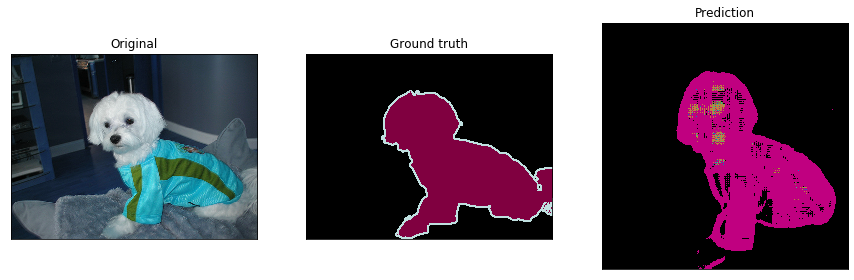

In [40]:
import scipy.misc
import cv2

name = "2009_003466"

inp_image = "../Data/JPEGImages/"+name+".jpg"
tru_image = "../Data/SegmentationClass/"+name+".png"

original = cv2.imread(inp_image)
truth = cv2.imread(tru_image)
predicted = get_predicted_image(original, get_image_labels(inp_image))
print(predicted.shape)

plot_imgs([original, truth, predicted], ["Original", "Ground truth", "Prediction"], (15, 15))

In [0]:
get_image_labels(inp_image)[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])